## Sentiment Based Product Recommendation System
### By: Palak Kakkar

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import *
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
import nltk
import re
from sklearn import model_selection
import pickle
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import textblob
from textblob import TextBlob
from textblob import Word
from imblearn.over_sampling import SMOTE

In [2]:
# Reading ratings file
rating = pd.read_csv('sample30.csv')
rating.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


### Data Analysis

In [3]:
# analysing the data
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [4]:
#missing values
print("Percentage of missing values :")
missing_val = rating.isna().sum() / len(rating) * 100
missing_val.sort_values(ascending = False).head(50).round(4)

Percentage of missing values :


reviews_userProvince    99.4333
reviews_userCity        93.5700
reviews_didPurchase     46.8933
reviews_doRecommend      8.5667
reviews_title            0.6333
manufacturer             0.4700
reviews_username         0.2100
reviews_date             0.1533
user_sentiment           0.0033
id                       0.0000
brand                    0.0000
categories               0.0000
name                     0.0000
reviews_rating           0.0000
reviews_text             0.0000
dtype: float64

In [5]:
#dropping the columns with more than 90% of missing values
rating.drop(['reviews_userProvince', 'reviews_userCity'], axis=1, inplace = True)

In [6]:
#checking the data info post removal of above columns
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   30000 non-null  object
 1   brand                30000 non-null  object
 2   categories           30000 non-null  object
 3   manufacturer         29859 non-null  object
 4   name                 30000 non-null  object
 5   reviews_date         29954 non-null  object
 6   reviews_didPurchase  15932 non-null  object
 7   reviews_doRecommend  27430 non-null  object
 8   reviews_rating       30000 non-null  int64 
 9   reviews_text         30000 non-null  object
 10  reviews_title        29810 non-null  object
 11  reviews_username     29937 non-null  object
 12  user_sentiment       29999 non-null  object
dtypes: int64(1), object(12)
memory usage: 3.0+ MB


#### We are not imputing any missing values currently as going forward, we'll be keeping only those columns which are needed for the analysis and dropping the rest.

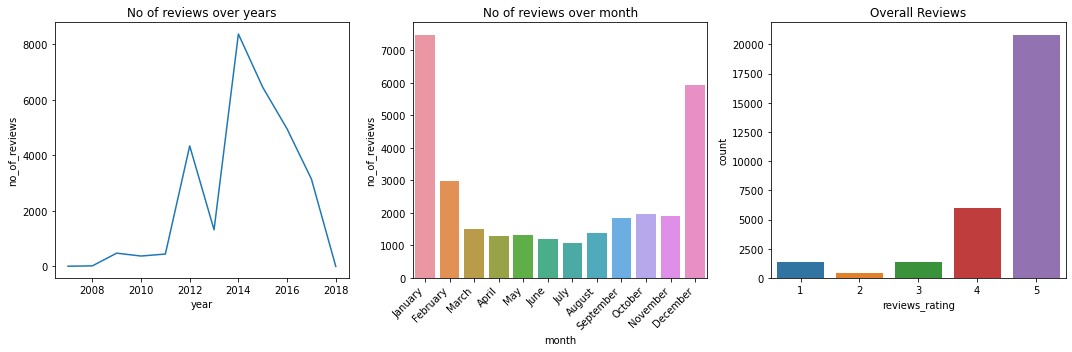

In [7]:
#Analysing the data visually
#--- split the date into seperate columns of date month and year
#--- extract date from the reviews_date column
rating['reviews_onlydate'] = rating['reviews_date'].str[:10]
rating['reviews_onlydate'].head()
#--- split the date into seperate columns of date month and year
#--- set the datatype to the above extracted date column
rating['reviews_onlydate'] = pd.to_datetime(rating['reviews_onlydate'], errors='coerce').dt.date
rating['reviews_onlydate'].fillna(rating['reviews_onlydate'].value_counts().idxmax(),inplace=True)
rating['reviews_onlydate'] = pd.to_datetime(rating.reviews_onlydate, format='%Y-%m-%d')
rating['reviews_onlydate'].head()
#--- split the date into seperate columns of date month and year
rating['month'] = rating['reviews_onlydate'].dt.month
rating['year'] = rating['reviews_onlydate'].dt.year
f, axes = plt.subplots(1,3, figsize=(15,5))
#--- Yearly Reviews
yearly = rating.groupby(['year'])['reviews_username'].count().reset_index()
yearly = yearly.rename(columns={'reviews_username':'no_of_reviews'})
yearChart = sns.lineplot(x='year',y='no_of_reviews',data=yearly, ax = axes[0])
yearChart.set_title('No of reviews over years')

#--- Monthly Reviews
monthly = rating.groupby(['month'])['reviews_username'].count().reset_index()
monthly['month'] = monthly['month'].apply(lambda x : calendar.month_name[x])
monthly = monthly.rename(columns={'reviews_username':'no_of_reviews'})
monthChart = sns.barplot(x='month',y='no_of_reviews',data=monthly, ax = axes[1])
monthChart.set_title('No of reviews over month')
monthChart.set_xticklabels(monthChart.get_xticklabels(), rotation = 45, horizontalalignment = 'right')

#-- Getting overall ratings for all products
sns.countplot(x = 'reviews_rating', data = rating, ax = axes[2] ).set_title('Overall Reviews')

f.tight_layout()

<AxesSubplot:>

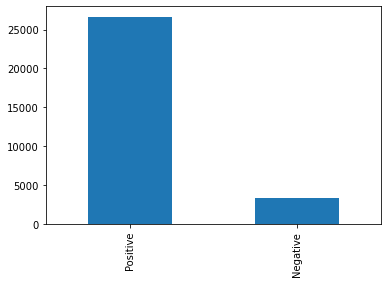

In [8]:
#anylysing the user sentiments (positive or negative)
rating['user_sentiment'].value_counts().plot.bar()

<AxesSubplot:>

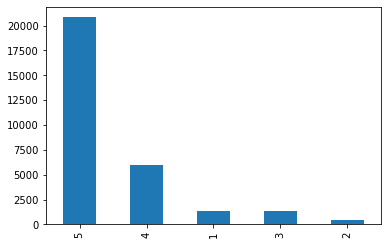

In [9]:
#rating values giving by the users
rating['reviews_rating'].value_counts().plot.bar()

In [10]:
# selecting only columns whih are needed for the further analysis 
rating = rating[['name', 'reviews_username', 'reviews_rating', 'user_sentiment', 'reviews_text']]
rating.head()

,name,reviews_username,reviews_rating,user_sentiment,reviews_text
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5,Positive,i love this album. it's very good. more to the...
1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5,Positive,Good flavor. This review was collected as part...
2,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5,Positive,Good flavor.
3,K-Y Love Sensuality Pleasure Gel,rebecca,1,Negative,I read through the reviews on here before look...
4,K-Y Love Sensuality Pleasure Gel,walker557,1,Negative,My husband bought this gel for us. The gel cau...


###  Pre - processing

In [11]:
# pre processing of the data
#removing hyperlinks and urls
rating['reviews'] = rating['reviews_text'].apply(lambda x: re.sub(r"http\S+", "", x))
rating['reviews']

0        i love this album. it's very good. more to the...
1        Good flavor. This review was collected as part...
2                                             Good flavor.
3        I read through the reviews on here before look...
4        My husband bought this gel for us. The gel cau...
                               ...                        
29995    I got this conditioner with Influenster to try...
29996    I love it , I received this for review purpose...
29997    First of all I love the smell of this product....
29998    I received this through Influenster and will n...
29999    I received this product complimentary from inf...
Name: reviews, Length: 30000, dtype: object

In [12]:
#Perform the Contractions on the reviews.
def contractions(s):
    s = re.sub(r"won’t", "will not",s)
    s = re.sub(r"would’t", "would not",s)
    s = re.sub(r"could’t", "could not",s)
    s = re.sub(r"\’d", " would",s)
    s = re.sub(r"can\’t", "can not",s)
    s = re.sub(r"n\’t", " not", s)
    s= re.sub(r"\’re", " are", s)
    s = re.sub(r"\’s", " is", s)
    s = re.sub(r"\’ll", " will", s) 
    s = re.sub(r"\’t", " not", s)
    s = re.sub(r"\’ve", " have", s)
    s = re.sub(r"\’m", " am", s)
    return s

In [13]:
#applying contractions function on data
rating['reviews'] = rating['reviews'].apply(contractions)

In [14]:
#removal of stop words
#import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
#X=rating['reviews']
#X = X.apply(lambda x:" ".join([x for x in x.split() if x not in stop]))
rating['reviews'] = rating['reviews'].apply(lambda x:" ".join([x for x in x.split() if x not in stop]))

In [15]:
#Tokenize the review text to words
reg = re.compile('[^a-zA-Z]+')
def tokenizedReviews(text):
    text = text.lower()
    text = reg.sub(' ', text).strip()
    return text

In [16]:
#applying tokenizer function on data
rating['reviews'] = rating['reviews'].apply(tokenizedReviews)
rating['reviews']

0        love album good hip hop side current pop sound...
1         good flavor this review collected part promotion
2                                              good flavor
3        i read reviews looking buying one couples lubr...
4        my husband bought gel us the gel caused irrita...
                               ...                        
29995    i got conditioner influenster try im loving fa...
29996    i love i received review purposes influenster ...
29997    first i love smell product after wash hair smo...
29998    i received influenster never go back anything ...
29999    i received product complimentary influenster r...
Name: reviews, Length: 30000, dtype: object

In [17]:
#reviewing the data
rating.head()

,name,reviews_username,reviews_rating,user_sentiment,reviews_text,reviews
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5,Positive,i love this album. it's very good. more to the...,love album good hip hop side current pop sound...
1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5,Positive,Good flavor. This review was collected as part...,good flavor this review collected part promotion
2,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5,Positive,Good flavor.,good flavor
3,K-Y Love Sensuality Pleasure Gel,rebecca,1,Negative,I read through the reviews on here before look...,i read reviews looking buying one couples lubr...
4,K-Y Love Sensuality Pleasure Gel,walker557,1,Negative,My husband bought this gel for us. The gel cau...,my husband bought gel us the gel caused irrita...


In [18]:
# as we've got our reviews processed and in better format, we'll drop the earlier reviews_text column: 
rating = rating.drop(['reviews_text'], axis=1)

In [19]:
#As we have got out data ready for further  analysis, we will create a pkl file of the data for later reference.
pickle.dump(rating, open('rating.pkl','wb'))

In [20]:
# checking sentiment values
rating['user_sentiment'].value_counts()

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

In [21]:
#getting numeric values for user sentiments
def sentiments(txt):
    if str(txt).lower() == 'positive':
        return 1
    else:
        return 0
    
rating['user_sentiment'] = rating['user_sentiment'].apply(sentiments)

In [22]:
# checking sentiment values
rating['user_sentiment']

0        1
1        1
2        1
3        0
4        0
        ..
29995    1
29996    1
29997    1
29998    1
29999    1
Name: user_sentiment, Length: 30000, dtype: int64

In [23]:
#defining vaues for X and y for analysis
X=rating['reviews']
y=rating['user_sentiment']

In [24]:
#defining the tfidf function to be used later
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', stop_words= 'english')

In [25]:
# checking sentiment values
rating['user_sentiment'].value_counts()

1    26632
0     3368
Name: user_sentiment, dtype: int64

In [26]:
# Above values for user sentiments show imbalance, as values for 1(positive) are much higher than 0(negative). 
#Lets handle this imbalance in the next step
# handling class imbalance
tdidf_features=tfidf.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(tdidf_features, y, test_size=0.2, random_state=31)
sm=SMOTE()
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
X_test_smote, y_test_smote = sm.fit_resample(X_test, y_test)

In [27]:
#As we have got our data processed with tfidf, we'll save a pkl file with the tfidf to be used later 
filename = 'tfidf'
pickle.dump(tfidf, open(filename, 'wb'))

In [28]:
#defining the function for the analysis of getting the best suited model
def model(X_train_smote, y_train_smote, X_test_smote, y_test_smote, ml_model, coef_show=1):
    
    clf = ml_model.fit(X_train_smote, y_train_smote)
    clf_pred = clf.predict(X_test_smote)
    accuracy = clf.score(X_test_smote, y_test_smote)
    model_performance = classification_report(y_test_smote, clf_pred)
    validation_pred_proba_grad = clf.predict_proba(X_test_smote)
    roc_auc = roc_auc_score(y_test_smote, validation_pred_proba_grad[:,1])
    print ('accuracy of the model: ', accuracy)
    print('')
    print(model_performance)
    print('')
    print('ROC_AUC score: ', roc_auc)
    
    if coef_show == 1:
        w = tfidf.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('Top 10 positive features (variables)')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('Top 10 negative features (variables)')        
        print(coeff_df.tail(20).to_string(index=False))
    
    return clf

### Logistic Regression

In [29]:
#logistic regression
logistic = model(X_train_smote, y_train_smote, X_test_smote, y_test_smote, LogisticRegression())

accuracy of the model:  0.9386818947762591

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5341
           1       0.95      0.93      0.94      5341

    accuracy                           0.94     10682
   macro avg       0.94      0.94      0.94     10682
weighted avg       0.94      0.94      0.94     10682


ROC_AUC score:  0.9824216307761955

Top 10 positive features (variables)
        Word  Coefficient
       great    17.985673
        love    15.167291
        best    12.346663
        easy    11.142868
        good    10.972964
       clean    10.660654
       loved     8.708027
   excellent     8.237413
        nice     8.237127
     perfect     8.159082
      better     8.111163
     awesome     7.564437
    favorite     7.245331
     enjoyed     7.214303
     amazing     7.070447
   wonderful     6.334819
        free     6.220174
entertaining     5.936674
       liked     5.869185
       handy     5.783110

Top 10 n

In [30]:
# saving the model to disk for future reference
filename = 'logistic_model.pkl'
pickle.dump(logistic, open(filename, 'wb'))

### Naive Bayes Modeling

In [31]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

In [32]:
#MultinomialNB
Multinomialnaive = model(X_train_smote, y_train_smote, X_test_smote, y_test_smote, MultinomialNB())

accuracy of the model:  0.7999438307433065

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      5341
           1       0.77      0.86      0.81      5341

    accuracy                           0.80     10682
   macro avg       0.80      0.80      0.80     10682
weighted avg       0.80      0.80      0.80     10682


ROC_AUC score:  0.8867707816521895

Top 10 positive features (variables)
     Word  Coefficient
    great    -3.918943
     love    -4.006415
   review    -4.116851
promotion    -4.133182
collected    -4.133419
    movie    -4.164968
      use    -4.209470
  product    -4.287253
     good    -4.394479
    wipes    -4.422768
    clean    -4.426658
   clorox    -4.573753
     easy    -4.677896
     like    -4.859112
     hair    -4.971085
   really    -5.040678
 godzilla    -5.093547
    smell    -5.095349
 cleaning    -5.099006
     best    -5.117178

Top 10 negative features (variables)
         Word  Coefficient
       

C:\Users\pkakkar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [33]:
#BernoulliNB
Bernoullinaive = model(X_train_smote, y_train_smote, X_test_smote, y_test_smote, BernoulliNB())

accuracy of the model:  0.8219434562815952

              precision    recall  f1-score   support

           0       0.84      0.79      0.82      5341
           1       0.80      0.85      0.83      5341

    accuracy                           0.82     10682
   macro avg       0.82      0.82      0.82     10682
weighted avg       0.82      0.82      0.82     10682


ROC_AUC score:  0.8921599349035368

Top 10 positive features (variables)
     Word  Coefficient
   review    -1.200051
collected    -1.214185
promotion    -1.214185
    great    -1.243065
     love    -1.314060
      use    -1.482084
  product    -1.592811
    movie    -1.763925
    wipes    -1.860826
    clean    -1.868707
     good    -1.915111
   clorox    -2.067351
     like    -2.119935
     easy    -2.198023
   really    -2.444274
    using    -2.551561
     hair    -2.559423
    smell    -2.631152
     time    -2.643623
     best    -2.694430

Top 10 negative features (variables)
         Word  Coefficient
       

C:\Users\pkakkar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


### Random forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
rndm_forest = RandomForestClassifier(n_estimators=100, max_depth=20, max_features=100, random_state=31, oob_score=True)
randomforest = model(X_train_smote, y_train_smote, X_test_smote, y_test_smote, rndm_forest, coef_show=0)

accuracy of the model:  0.8876614866129938

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      5341
           1       0.92      0.85      0.88      5341

    accuracy                           0.89     10682
   macro avg       0.89      0.89      0.89     10682
weighted avg       0.89      0.89      0.89     10682


ROC_AUC score:  0.9549016045940233


In [36]:
# defining function for the analysis of the models tested above
def predict_model(X_train, y_train, X_test, y_test, model):
    #if model == LogisticRegression:
    #    model = model()
    #else:
    #    model = model(n_estimators = trees)
    #model = model()
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:,1]
    return y_pred, y_pred_probs

In [37]:
#defininf the function for making ROC plots for the models tested
def ROC_curve_plots(y_test,y_pred_probs1, y_pred_probs2, y_pred_probs3, y_pred_probs4, model1, model2, model3, model4):
    fpr1, tpr1, _ = roc_curve(y_test, y_pred_probs1)
    auc1 = roc_auc_score(y_test, y_pred_probs1)
    fpr2, tpr2, _ = roc_curve(y_test, y_pred_probs2)
    auc2 = roc_auc_score(y_test, y_pred_probs2)
    fpr3, tpr3, _ = roc_curve(y_test, y_pred_probs3)
    auc3 = roc_auc_score(y_test, y_pred_probs3) 
    fpr4, tpr4, _ = roc_curve(y_test, y_pred_probs4)
    auc4 = roc_auc_score(y_test, y_pred_probs4) 
    plt.figure(1,figsize=(12,8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr1, tpr1, label=f'{model1} AUC={round(auc1,3)}')
    plt.plot(fpr2, tpr2, label=f'{model2} AUC={round(auc2,3)}')
    plt.plot(fpr3, tpr3, label=f'{model3} AUC={round(auc3,3)}')
    plt.plot(fpr4, tpr4, label=f'{model4} AUC={round(auc4,3)}')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    return

In [38]:
# calling functionf with the required values
y_pred1, y_pred_probs1 = predict_model(X_train_smote, y_train_smote, X_test_smote, y_test_smote, LogisticRegression())
y_pred2, y_pred_probs2 = predict_model(X_train_smote, y_train_smote, X_test_smote, y_test_smote, MultinomialNB())
y_pred3, y_pred_probs3 = predict_model(X_train_smote, y_train_smote, X_test_smote, y_test_smote, BernoulliNB())
y_pred4, y_pred_probs4 = predict_model(X_train_smote, y_train_smote, X_test_smote, y_test_smote, rndm_forest)

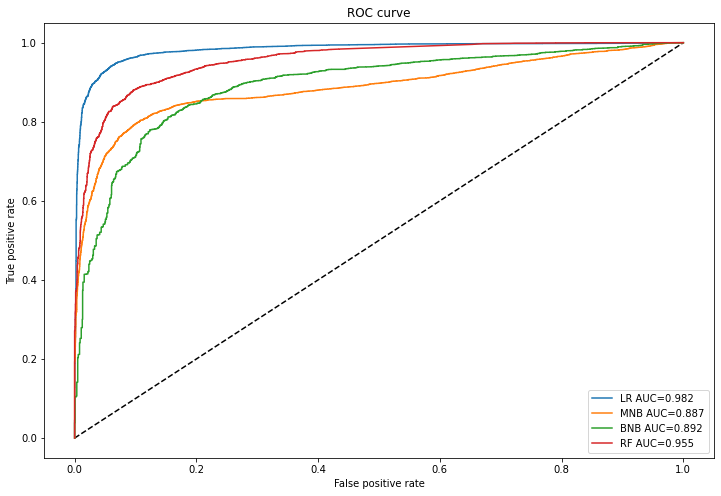

In [39]:
#plotting ROC values
ROC_curve_plots(y_test_smote,y_pred_probs1, y_pred_probs2,y_pred_probs3, y_pred_probs4, 'LR', 'MNB','BNB', 'RF')

## As the logistic regression is giving best results we will proceed with  logistic regression

#######################################################################################################################

In [40]:
# Reading ratings file 
ratings = pd.read_csv('sample30.csv' , encoding='latin-1')
ratings.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


## Dividing the dataset into train and test

In [41]:
#Test and Train split of the dataset.
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.2, random_state=31)

In [42]:
print(train.shape)
print(test.shape)

(24000, 15)
(6000, 15)


In [43]:
# Pivot the train ratings' dataset into matrix format in which columns are movies and the rows are user IDs.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(0)

df_pivot.head(3)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating dummy train & dummy test dataset
These dataset will be used for prediction 
- Dummy train will be used later for prediction of the movies which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [44]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [45]:
# The movies not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [46]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(1)

In [47]:
dummy_train.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case] 

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different movies.



# User Similarity Matrix

## Using Cosine Similarity

In [48]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]]


In [49]:
user_correlation.shape

(20547, 20547)

## Using adjusted Cosine 

### Here, we are not removing the NaN values and calculating the mean only for the movies rated by the user

In [50]:
# Create a user-movie matrix.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)

In [51]:
df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalising the rating of the movie for each user around 0 mean

In [52]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [53]:
df_subtracted.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finding cosine similarity

In [54]:
from sklearn.metrics.pairwise import pairwise_distances

In [55]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [56]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for movies rated as well as not rated) is the weighted sum of correlation with the movie rating (as present in the rating dataset). 

In [57]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [58]:
user_predicted_ratings.shape

(20547, 256)

Since we are interested only in the movies not rated by the user, we will ignore the movies rated by the user by making it zero. 

In [59]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
# saving the user_rating model for future use
filename = 'user_rating.pkl'
pickle.dump(user_final_rating, open(filename, 'wb'))

### Finding the top 5 recommendation for the *user*

In [61]:
# Take the user ID as input.
user_input = input("Enter your user name")
print(user_input)

Enter your user name06stidriver
06stidriver


In [62]:
user_final_rating.head(2)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
d

name
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest    0.0
100:Complete First Season (blu-Ray)                              0.0
Ogx Anti-breakage Keratin Oil 3 Minute Miraculous Recovery       0.0
Ogx Conditioner, Hydrating Teatree Mint                          0.0
Olay Moisturizing Lotion For Sensitive Skin                      0.0
Name: 06stidriver, dtype: float64

# Evaluation - User User 

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user. 

In [64]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1509, 15)

In [65]:
common.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
20634,AVpfkak01cnluZ0-nJj6,Starbucks,"Food & Beverage,Coffee, Tea & Cocoa,Coffee,Foo...",American Coffee Partnership,Starbucks Iced Expresso Classics Vanilla Latte...,2016-04-21T00:00:00.000Z,False,True,5,Love it!,Love the taste! Would have highly recommended!,NaN,NaN,girlie,Positive
26479,AVpfPPkEilAPnD_xX3cP,Aveeno,"Personal Care,Sun Care,Featured Brands,Health ...",Aveeno Baby,Aveeno Baby Continuous Protection Lotion Sunsc...,2013-07-05T00:00:00Z,NaN,NaN,1,"My 6 year old daughter has sensitive skin, and...",Not sensitive enough,NaN,NaN,kasheville,Positive
15098,AVpf4oLxLJeJML43FcxC,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2009-08-11T00:00:00.000Z,NaN,True,5,"Wow, what a difference ease makes. Thanks for ...",Best Ever,NaN,NaN,arlene,Positive
17968,AVpfcu821cnluZ0-k8ep,Vaseline,"Personal Care,Skin Care,Lip Care,Beauty,Makeup...",UNILEVER,Vaseline Intensive Care Lip Therapy Cocoa Butter,2015-04-29T00:00:00.000Z,False,True,5,Love this product. Its amazing. Made my lips s...,wonderful,NaN,NaN,mimi3,Positive
28020,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2015-05-20T00:00:00.000Z,NaN,True,5,This movie is wonderful. It has a great story ...,Great Family Movie,NaN,NaN,movielover,Positive


In [66]:
# convert into the user-movie matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [67]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [68]:
df_subtracted.head(1)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20537,20538,20539,20540,20541,20542,20543,20544,20545,20546
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
common.head(1)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
20634,AVpfkak01cnluZ0-nJj6,Starbucks,"Food & Beverage,Coffee, Tea & Cocoa,Coffee,Foo...",American Coffee Partnership,Starbucks Iced Expresso Classics Vanilla Latte...,2016-04-21T00:00:00.000Z,False,True,5,Love it!,Love the taste! Would have highly recommended!,NaN,NaN,girlie,Positive


In [71]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [72]:
user_correlation_df_1.shape

(1327, 20547)

In [73]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [74]:
user_correlation_df_3 = user_correlation_df_2.T

In [75]:
user_correlation_df_3.head()

,00sab00,1234,123charlie,4djs,7inthenest,a hutch,aaron,abc,abcssds,abigail,...,xavier,xmom,yellow,yesseniaw22,yeyo,ygtz,yoadrian,yohnie1,yvonne,zebras
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4djs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7inthenest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
user_correlation_df_3.shape

(1327, 1327)

In [77]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [78]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

In [79]:
dummy_test.shape

(1327, 112)

In [80]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [81]:
common_user_predicted_ratings.head(2)

name,100:Complete First Season (blu-Ray),"42 Dual Drop Leaf Table with 2 Madrid Chairs""",Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Batherapy Natural Mineral Bath Sport Liquid, 16 oz","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",...,Tostitos Original Restaurant Style Tortilla Chips,Tresemme Kertatin Smooth Infusing Conditioning,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculating the RMSE for only the movies rated by user. For RMSE, normalising the rating to (1,5) range.

In [82]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


C:\Users\pkakkar\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\pkakkar\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [83]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [84]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [85]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.61559547237573


## Using Item similarity

# Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different movie ID. In the user based similarity, we had taken mean for each user instead of each movie. 

In [86]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00dog3,00sab00,01impala,0325home,06stidriver,08dallas,09mommy11,1085,10ten,11111111aaaaaaaaaaaaaaaaa,...,zpalma,zsazsa,zt313,zubb,zulaa118,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalising the movie rating for each movie for using the Adujsted Cosine

In [87]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [88]:
df_subtracted.head()

reviews_username,00dog3,00sab00,01impala,0325home,06stidriver,08dallas,09mommy11,1085,10ten,11111111aaaaaaaaaaaaaaaaa,...,zpalma,zsazsa,zt313,zubb,zulaa118,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,0.277273,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finding the cosine similarity using pairwise distances approach

In [89]:
from sklearn.metrics.pairwise import pairwise_distances

In [90]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ... -0.00578588  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.         -0.00578588  0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [91]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Prediction - Item Item

In [92]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.0166165 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01427425, 0.        , ..., 0.        , 0.00197801,
        0.0024673 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.00151252,
        0.        ],
       [0.        , 0.01716194, 0.        , ..., 0.03771556, 0.00825727,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00121001,
        0.        ]])

In [93]:
item_predicted_ratings.shape

(20547, 256)

In [94]:
dummy_train.shape

(20547, 256)

### Filtering the rating only for the movies not rated by the user for recommendation

In [95]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.016616,0.000000,0.000000
00sab00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.003000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
01impala,0.0,0.014274,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.006033,0.0,0.0,0.005502,0.002717,0.0,0.0,0.000000,0.001978,0.002467
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001067,0.003058,...,0.000000,0.0,0.0,0.006117,0.000000,0.0,0.0,0.000000,0.001513,0.000000
06stidriver,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001067,0.003058,...,0.000000,0.0,0.0,0.006117,0.000000,0.0,0.0,0.000000,0.001513,0.000000


In [96]:
# save the model to disk
filename = 'item_rating.pkl'
pickle.dump(item_final_rating, open(filename, 'wb'))

### Finding the top 5 recommendation for the *user*



In [97]:
# Take the user ID as input
user_input = input("Enter your user name")
print(user_input)

Enter your user name06stidriver
06stidriver


In [98]:
# Recommending the Top 5 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
d

name
Clorox Disinfecting Bathroom Cleaner                                              0.916251
Newman's Own Organics Licorice Twist, Black 5oz                                   0.020838
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz    0.017940
Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz                        0.012445
Queen Helene Cocoa Butter Solid                                                   0.012233
Name: 06stidriver, dtype: float64

# Evaluation - Item Item

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user. 

In [99]:
test.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_userCity',
       'reviews_userProvince', 'reviews_username', 'user_sentiment'],
      dtype='object')

In [100]:
common =  test[test.name.isin(train.name)]
common.shape

(5984, 15)

In [101]:
common.head(4)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
4332,AVpe9W4D1cnluZ0-avf0,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,2010-09-10T00:00:00.000Z,False,True,5,I've only owned this product for 4 weeks so co...,Great buy,NaN,NaN,sansname,Positive
3434,AVpe5s3RLJeJML43x4eA,Pantene,"Personal Care,Hair Care,Conditioner,Beauty,Sha...",Pantene Pro-V Hair Care,Pantene Pro-V Expert Collection Age Defy Condi...,2016-04-08T00:00:00.000Z,False,NaN,5,This is thick stuff! I was surprised by the co...,Serious conditioning!,NaN,NaN,jennypstrong,Positive
20634,AVpfkak01cnluZ0-nJj6,Starbucks,"Food & Beverage,Coffee, Tea & Cocoa,Coffee,Foo...",American Coffee Partnership,Starbucks Iced Expresso Classics Vanilla Latte...,2016-04-21T00:00:00.000Z,False,True,5,Love it!,Love the taste! Would have highly recommended!,NaN,NaN,girlie,Positive
26479,AVpfPPkEilAPnD_xX3cP,Aveeno,"Personal Care,Sun Care,Featured Brands,Health ...",Aveeno Baby,Aveeno Baby Continuous Protection Lotion Sunsc...,2013-07-05T00:00:00Z,NaN,NaN,1,"My 6 year old daughter has sensitive skin, and...",Not sensitive enough,NaN,NaN,kasheville,Positive


In [102]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [103]:
common_item_based_matrix.shape

(181, 5679)

In [104]:
item_correlation_df = pd.DataFrame(item_correlation)

In [105]:
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
list_name = common.name.tolist()

In [108]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [109]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [110]:
item_correlation_df_3.head()

,100:Complete First Season (blu-Ray),Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",...,Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
100:Complete First Season (blu-Ray),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
Alex Cross (dvdvideo),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.027031,0.0,0.0,0.0,0.0,0.0,0.0,0.00286,0.0,0.0
"All,bran Complete Wheat Flakes, 18 Oz.",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [111]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.01029717, 0.02379042, 0.01903234, ..., 0.        , 0.01234132,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03580253, 0.        , 0.        , ..., 0.0010674 , 0.        ,
        0.0010674 ],
       ...,
       [0.02262934, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00495436, 0.00329668, 0.00263734, ..., 0.00151252, 0.        ,
        0.00151252],
       [0.        , 0.00411216, 0.00328973, ..., 0.        , 0.        ,
        0.        ]])

In [112]:
common_item_predicted_ratings.shape

(181, 5679)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train



In [113]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.


In [114]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [115]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


C:\Users\pkakkar\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\pkakkar\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [116]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [117]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5954283481298033


## As the user similarity is giving better results we will proceed with user similarity

In [118]:
# importing the data
final = pd.read_csv("sample30.csv")

In [119]:
#importing the earlier exported tfidf pkl, for processing
tdidftrans = pickle.load(open("tfidf", "rb"))

In [120]:
#applying the tfidf pkl function on the data
tfidfFeatures = tdidftrans.transform(final.reviews_text)

In [121]:
#importing the logistic model pickel file
logistic_model = pickle.load(open("logistic_model.pkl", "rb"))

In [122]:
#Do reviews classification as good or bad sentiment.
classifiedsenti=logistic_model.predict(tfidfFeatures)

In [123]:
#Merge the class to the dataframe
sntmtClassSeries = pd.Series(classifiedsenti, name = "class_sent")
final = final.join(sntmtClassSeries)
print(final[['manufacturer', 'name', 'reviews_text', 'class_sent']])

                             manufacturer  \
0      Universal Music Group / Cash Money   
1                                Lundberg   
2                                Lundberg   
3                                     K-Y   
4                                     K-Y   
...                                   ...   
29995                       L'oreal Paris   
29996                       L'oreal Paris   
29997                       L'oreal Paris   
29998                       L'oreal Paris   
29999                       L'oreal Paris   

                                                    name  \
0              Pink Friday: Roman Reloaded Re-Up (w/dvd)   
1             Lundberg Organic Cinnamon Toast Rice Cakes   
2             Lundberg Organic Cinnamon Toast Rice Cakes   
3                       K-Y Love Sensuality Pleasure Gel   
4                       K-Y Love Sensuality Pleasure Gel   
...                                                  ...   
29995  L'or233al Paris Elvive Extraordi

In [124]:
#organizing the data
groupedDf = final.groupby(['name'])
product_class = groupedDf['class_sent'].agg(mean_class=np.mean)

In [125]:
#checking the class for the data and the info related to the data
print(type(product_class))
print(product_class.info)

<class 'pandas.core.frame.DataFrame'>
<bound method DataFrame.info of                                                     mean_class
name                                                          
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. F...    0.666667
100:Complete First Season (blu-Ray)                   0.884892
2017-2018 Brownline174 Duraflex 14-Month Planne...    0.000000
2x Ultra Era with Oxi Booster, 50fl oz                1.000000
42 Dual Drop Leaf Table with 2 Madrid Chairs"         1.000000
...                                                        ...
Weleda Everon Lip Balm                                1.000000
Wilton Black Dots Standard Baking Cups                1.000000
Windex Original Glass Cleaner Refill 67.6oz (2 ...    0.721264
Yes To Carrots Nourishing Body Wash                   0.984615
Yes To Grapefruit Rejuvenating Body Wash              0.743590

[271 rows x 1 columns]>


In [126]:
#checking the index for the product_class
product_class.index

Index(['0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest',
       '100:Complete First Season (blu-Ray)',
       '2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black',
       '2x Ultra Era with Oxi Booster, 50fl oz',
       '42 Dual Drop Leaf Table with 2 Madrid Chairs"',
       '4C Grated Parmesan Cheese 100% Natural 8oz Shaker',
       '5302050 15/16 FCT/HOSE ADAPTOR',
       'Africa's Best No-Lye Dual Conditioning Relaxer System Super',
       'Alberto VO5 Salon Series Smooth Plus Sleek Shampoo',
       'Alex Cross (dvdvideo)',
       ...
       'Walkers Stem Ginger Shortbread',
       'Wallmount Server Cabinet (450mm, 9 RU)',
       'Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee',
       'WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black',
       'Wedding Wishes Wedding Guest Book', 'Weleda Everon Lip Balm',
       'Wilton Black Dots Standard Baking Cups',
       'Windex Original 

In [127]:
# Pringint the values from the dataframe
for x in product_class.index:
    print(product_class.loc[x])

mean_class    0.666667
Name: 0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest, dtype: float64
mean_class    0.884892
Name: 100:Complete First Season (blu-Ray), dtype: float64
mean_class    0.0
Name: 2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black, dtype: float64
mean_class    1.0
Name: 2x Ultra Era with Oxi Booster, 50fl oz, dtype: float64
mean_class    1.0
Name: 42 Dual Drop Leaf Table with 2 Madrid Chairs", dtype: float64
mean_class    0.833333
Name: 4C Grated Parmesan Cheese 100% Natural 8oz Shaker, dtype: float64
mean_class    0.0
Name: 5302050 15/16 FCT/HOSE ADAPTOR, dtype: float64
mean_class    0.833333
Name: Africa's Best No-Lye Dual Conditioning Relaxer System Super, dtype: float64
mean_class    0.666667
Name: Alberto VO5 Salon Series Smooth Plus Sleek Shampoo, dtype: float64
mean_class    0.801418
Name: Alex Cross (dvdvideo), dtype: float64
mean_class    0.454545
Name: All,bran Complete Wheat Flakes, 18 Oz., dtype: float64
mean_class    1.0
Name:

Name: Kendall Comforter And Sheet Set (twin) Aqua - 7pc, dtype: float64
mean_class    0.0
Name: Kenroy Home Table Lamp - Chrome, dtype: float64
mean_class    0.4
Name: Kikkoman Soy Sauce, 5fl oz, dtype: float64
mean_class    0.823529
Name: Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count, dtype: float64
mean_class    1.0
Name: Kind Nut Delight Bar, dtype: float64
mean_class    1.0
Name: King Ralph (dvd), dtype: float64
mean_class    0.75
Name: Kohler 10280-4 Fort Bath Spout With Sculpted Lift Rod and 1/2-in NPT Connection, dtype: float64
mean_class    0.891892
Name: Kraus FVS-1007 Single Hole Vessel Bathroom Faucet from the Ramus Collection, dtype: float64
mean_class    0.958685
Name: L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz, dtype: float64
mean_class    0.848485
Name: L'oreal Paris Advanced Hairstyle Boost It High Lift Creation Spray, dtype: float64
mean_class    0.652174
Name: L'oreal Paris Advanced Hairstyle TXT IT Hyper-Fix Putty, d

Name: Spam Single Classic, dtype: float64
mean_class    0.5
Name: Stacy's Garden Veggie Medley Pita Chips, dtype: float64
mean_class    0.75
Name: Stacy's Simply Naked Bagel Chips, dtype: float64
mean_class    0.384615
Name: Stander Pt Bedcane - Bed Handle, dtype: float64
mean_class    1.0
Name: Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz, dtype: float64
mean_class    0.666667
Name: Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz, dtype: float64
mean_class    0.924731
Name: Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo), dtype: float64
mean_class    0.0
Name: Stonyfield Yobaby Peach & Pear Yogurt 4oz 6 Ct, dtype: float64
mean_class    0.916667
Name: Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish, dtype: float64
mean_class    0.82
Name: Suave Professionals Hair Conditioner, Sleek, dtype: float64
mean_class    1.0
Name: Sunflower Swag With Metal Frame - Nearly Natural, dtype: float64
mean_class    0.666667
Name: Super Poli

In [128]:
# saving the final model to disk whch has all the pre processing completed and can be used for analyis
filename = 'sentiment_class.pkl'
pickle.dump(product_class, open(filename, 'wb'))

#### We've exported our final sentiment_class pkl, as this pk contains the already processed data with tfidf
#### and can be used drectly used by the user_rating pkl file for further analysis.

## Hence, We've got our classification model and the recommendation system based on our analysis: 
## > Logistic Regression
## > User based recommendation system

###########################################################################################################################